In [1]:
import pandas as pd
import json
import re
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.25)
plt.rcParams["figure.figsize"] = [8, 6]

In [2]:
df = pd.read_csv('timings_1.csv')
df['duration(s)'] = df['duration(µs)'] / 1_000_000
df_agg = df.groupby(["query","method","variant"]).aggregate(["count","mean","median","std"])
df_agg.columns = ['_'.join(col) for col in df_agg.columns]
df_agg.reset_index(inplace=True)
df_agg

,query,method,variant,duration(µs)_count,duration(µs)_mean,duration(µs)_median,duration(µs)_std,duration(s)_count,duration(s)_mean,duration(s)_median,duration(s)_std
0,10a,BinaryJoin,flatten,10,991404.9,991886.0,1775.468292,10,0.991405,0.991886,0.001775
1,10a,Yannakakis,flatten,10,961721.3,962102.0,1342.447686,10,0.961721,0.962102,0.001342
2,10b,BinaryJoin,flatten,10,599281.8,598863.5,3036.139940,10,0.599282,0.598863,0.003036
3,10b,Yannakakis,flatten,10,595699.1,595760.0,2885.609138,10,0.595699,0.595760,0.002886
4,10c,BinaryJoin,flatten,10,1171149.8,1056057.0,226360.265934,10,1.171150,1.056057,0.226360
...,...,...,...,...,...,...,...,...,...,...,...
219,9b,Yannakakis,flatten,10,412864.9,413070.0,1980.034144,10,0.412865,0.413070,0.001980
220,9c,BinaryJoin,flatten,10,568305.9,567345.0,5138.501586,10,0.568306,0.567345,0.005139
221,9c,Yannakakis,flatten,10,587902.8,587317.5,5827.572256,10,0.587903,0.587317,0.005828
222,9d,BinaryJoin,flatten,10,715809.2,716029.0,4377.442805,10,0.715809,0.716029,0.004377


In [3]:
# One record per query that contains both BinaryJoin and 2NSA (Yannakakis) results
# Be careful with interpreting these results: these timings also include the time spent by filtering input relations, aggregation, etc.
bj = df_agg[df_agg["method"] == "BinaryJoin"]
yann = df_agg[df_agg["method"] == "Yannakakis"]
joined = pd.merge(bj, yann, on='query', suffixes=('_bj', '_yann'))
projection = ['query', 'method_bj',
       'duration(s)_mean_bj', 'duration(s)_median_bj', 'duration(s)_std_bj',
       'method_yann', 'duration(s)_mean_yann',
       'duration(s)_median_yann', 'duration(s)_std_yann']
joined = joined[projection]
joined

# More detailed analysis (i.e., how much time is spent on join processing) is computed in the remainder of this notebook.

,query,method_bj,duration(s)_mean_bj,duration(s)_median_bj,duration(s)_std_bj,method_yann,duration(s)_mean_yann,duration(s)_median_yann,duration(s)_std_yann
0,10a,BinaryJoin,0.991405,0.991886,0.001775,Yannakakis,0.961721,0.962102,0.001342
1,10b,BinaryJoin,0.599282,0.598863,0.003036,Yannakakis,0.595699,0.595760,0.002886
2,10c,BinaryJoin,1.171150,1.056057,0.226360,Yannakakis,0.873889,0.830928,0.098566
3,11a,BinaryJoin,0.092565,0.090860,0.007590,Yannakakis,0.090875,0.089447,0.004131
4,11b,BinaryJoin,0.052382,0.052496,0.001227,Yannakakis,0.051705,0.050872,0.001406
...,...,...,...,...,...,...,...,...,...
107,8d,BinaryJoin,3.888635,3.781860,0.306268,Yannakakis,0.811014,0.807720,0.014761
108,9a,BinaryJoin,0.785255,0.779861,0.035923,Yannakakis,0.746691,0.738797,0.023791
109,9b,BinaryJoin,0.392814,0.392059,0.003192,Yannakakis,0.412865,0.413070,0.001980
110,9c,BinaryJoin,0.568306,0.567345,0.005139,Yannakakis,0.587903,0.587317,0.005828


# 2NSA plans

For all 2NSA plans, compute the time spent by actual joining relations. In the context of 2NSA plans, the join time is the sum of times spent by the flatten, groupby and semijoin operators.

We compute the join time for each query as follows: from the reported metrics, we extract the total filter time, total projection time and total aggregation time. Subsequently, we subtract these times from the total query time to obtain the join time.

In [4]:
def replace_utf8_string(text):
    # Use regex to match and replace value: Utf8("SomeString") by value: Utf8(\"SomeString\")
    pattern = r'value:\s*Utf8\("(.*?)"\)'  # This matches 'value: Utf8("SomeString")'
    replacement = r'value: Utf8(\"\1\")'  # Adds escaped quotes: Utf8(\"SomeString\")
    
    result = re.sub(pattern, replacement, text)
    
    return result

metrics_file = "output/metrics.txt"
metrics = []
with open(metrics_file) as f:
    for i, line in enumerate(f):
        try:
            line = replace_utf8_string(line)
            metrics.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Error in line {i}")

projection = []

def filter_time(filternode):
    for metric in filternode["metrics"]:
        if metric["name"] == "elapsed_compute":
            return metric["value"]

    # filternode was never executed
    # can be due to early stopping in case of a multisemijoin with >=2 children.  
    return 0

def projection_time(projectionnode):
    for metric in projectionnode["metrics"]:
        if metric["name"] == "elapsed_compute":
            return metric["value"]

    # projectionnode was never executed
    # can be due to early stopping in case of a multisemijoin with >=2 children.  
    return 0

def aggregate_time(aggregatenode):
    for metric in aggregatenode["metrics"]:
        if metric["name"] == "elapsed_compute":
            return metric["value"]
    raise ValueError("aggregate_time metric not found")
        
def collect_timings(node, timings: dict):
    if node["operator"].startswith("FilterExec"):
        timings["filter_time"] += filter_time(node)
    elif node["operator"].startswith("ProjectionExec"):
        timings["projection_time"] += projection_time(node)
    elif node["operator"].startswith("Aggregate"):
        timings["aggregate_time"] += aggregate_time(node)

    for child in node["children"]:
        collect_timings(child, timings)


for entry in metrics:
    method = entry["params"]["method"]
    if method=="BinaryJoin": # skip binaryjoin, we're analyzing 2NSA now
        continue
    
    query = entry["params"]["query"]
    metrics = entry["plan"]["metrics"]
    row = {
        "method": method,   
        "query": query,
    }
    metrics = {"filter_time": 0, "projection_time": 0, "aggregate_time": 0}
    collect_timings(entry["plan"], metrics)
    # already convert all timings from ns to s
    metrics = {key: value / 1_000_000_000 for key, value in metrics.items()}
    row.update(metrics)
    projection.append(row)


yann_metrics = pd.DataFrame(projection)
yann_metrics = yann_metrics[[col for col in yann_metrics.columns if col != "method"]].groupby("query").aggregate(["median"])
yann_metrics.columns = ['_'.join(col) for col in yann_metrics.columns]

yann_metrics = pd.merge(
    yann_metrics,
    joined[["query","duration(s)_median_yann"]],
    on="query"
)

# join_time = total_time - filter_time - projection_time - aggregate_time
yann_metrics["yann_join_time_median"] = yann_metrics["duration(s)_median_yann"] - yann_metrics["filter_time_median"] - yann_metrics["projection_time_median"] - yann_metrics["aggregate_time_median"]
yann_metrics

,query,filter_time_median,projection_time_median,aggregate_time_median,duration(s)_median_yann,yann_join_time_median
0,10a,0.922849,0.001021,0.000129,0.962102,0.038103
1,10b,0.552141,0.001043,0.000114,0.595760,0.042462
2,10c,0.637654,0.001126,0.000156,0.830928,0.191992
3,11a,0.086827,0.000086,0.000031,0.089447,0.002503
4,11b,0.035132,0.000058,0.000022,0.050872,0.015660
...,...,...,...,...,...,...
107,8d,0.158852,0.001096,0.002608,0.807720,0.645164
108,9a,0.591207,0.001453,0.000194,0.738797,0.145944
109,9b,0.342779,0.000567,0.000218,0.413070,0.069506
110,9c,0.372343,0.001329,0.000392,0.587317,0.213254


# Binary plans (executed in Datafusion)

We now do the same for binary plans executed in Datafusion.

In [5]:
metrics_file = "output/metrics.txt"
metrics = []
with open(metrics_file) as f:
    for i, line in enumerate(f):
        try:
            line = replace_utf8_string(line)
            metrics.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Error in line {i}")

# Drop 2NSA plan metrics (we're now analyzing binary joins)
metrics = [metric for metric in metrics if metric["params"]["method"] == "BinaryJoin"]
print(len(metrics)) # should be nr_of_queries * 10 (10 repetitions)

1120


In [6]:
def get_metric(metric_name, metrics):
    for metric in metrics:
        if metric["name"] == metric_name:
            return metric

def collect_metrics(metrics):
    def update_timings(node):
        if node["operator"].startswith("AggregateExec"):
            timings["aggregate_time"] += get_metric("elapsed_compute", node["metrics"])["value"]
        elif node["operator"].startswith("FilterExec"):
            timings["filter_time"] += get_metric("elapsed_compute", node["metrics"])["value"]
        elif node["operator"].startswith("ProjectionExec"):
            timings["projection_time"] += get_metric("elapsed_compute", node["metrics"])["value"]
        # memoryexec does not contain timing metrics

        for child in node["children"]:
            update_timings(child)

    result = {}

    result["method"] = metrics["params"]["method"]
    result["query"] = metrics["params"]["query"]

    timings = {
        "aggregate_time": 0,
        "filter_time": 0,
        "projection_time": 0
    }
    root = metrics["plan"]
    update_timings(root)
    # all timings are in nanoseconds, convert to seconds
    timings = {k: v / 1_000_000_000 for k, v in timings.items()}
    result.update(timings)
    return result

datafusion_bj_metrics = pd.DataFrame([collect_metrics(m) for m in metrics])
datafusion_bj_metrics = datafusion_bj_metrics[[col for col in datafusion_bj_metrics.columns if col not in ["method"]]]
datafusion_bj_metrics = datafusion_bj_metrics.groupby("query").aggregate(["median"])
datafusion_bj_metrics.columns = ['_'.join(col)+"_datafusion" for col in datafusion_bj_metrics.columns]
datafusion_bj_metrics.reset_index(inplace=True)
datafusion_bj_metrics = pd.merge(
    joined[["query","duration(s)_median_bj"]],
    datafusion_bj_metrics,
    on="query"
)
# hashjoin time = total time - aggregate time - filter time - projection time
datafusion_bj_metrics["hashjoin_time_datafusion"] = datafusion_bj_metrics["duration(s)_median_bj"] - datafusion_bj_metrics["aggregate_time_median_datafusion"] - datafusion_bj_metrics["filter_time_median_datafusion"] - datafusion_bj_metrics["projection_time_median_datafusion"]
datafusion_bj_metrics

,query,duration(s)_median_bj,aggregate_time_median_datafusion,filter_time_median_datafusion,projection_time_median_datafusion,hashjoin_time_datafusion
0,10a,0.991886,0.000130,0.923882,0.001047,0.066827
1,10b,0.598863,0.000112,0.552329,0.001053,0.045369
2,10c,1.056057,0.000160,0.652596,0.001156,0.402145
3,11a,0.090860,0.000011,0.087123,0.000076,0.003651
4,11b,0.052496,0.000006,0.037539,0.000058,0.014893
...,...,...,...,...,...,...
107,8d,3.781860,0.002550,0.143772,0.001154,3.634384
108,9a,0.779861,0.000202,0.584251,0.001483,0.193925
109,9b,0.392059,0.000223,0.346210,0.000597,0.045028
110,9c,0.567345,0.000393,0.374718,0.001379,0.190855


# Binary plans (executed in DuckDB)

Next, we repeat the same analysis for binary join plans executed by DuckDB.

DuckDB has already computed the join time for each query (in their .html plans). There is one catch: the join time also includes the time spent by the 'MARK join'. DuckDB's optimizer rewrites large static IN clauses to a MARK join, so this actually belongs to filter time. We subtract the MARK join time from the reported join time by DuckDB to obtain the actual join time.

In [7]:
def total_mark_join_time(html):
    pattern = r"<b>\s*HASH JOIN\s*\(([\d|\.]+)s\)\s*<\/b>\s*</p>\s*<p>\s*MARK"
    mark_times = [float(match.group(1)) for match in re.finditer(pattern, html)]
    return sum(mark_times)

def extract_times_from_timing_table(html_file_path: str):
    with open(html_file_path, 'r') as file:
        content = file.read()
    
    soup = BeautifulSoup(content, 'html.parser')
    
    rows = soup.find_all('tr')
    
    execution_time = None
    seq_scan_time = None
    hashjoin_time = None
    aggregate_time = None
    projection_time = None
    filter_time = None
    
    for row in rows:
        cells = row.find_all('td')
        if len(cells) > 1:
            phase = cells[0].get_text(strip=True)
            time = cells[1].get_text(strip=True)
            
            if phase == 'Execution Time':
                execution_time = float(time)
            elif phase == 'SEQ_SCAN':
                seq_scan_time = float(time)
            elif phase == "HASH_JOIN":
                hashjoin_time = float(time)
            elif phase == "UNGROUPED_AGGREGATE":
                aggregate_time = float(time)
            elif phase == "PROJECTION":
                projection_time = float(time)
            elif phase == "FILTER":
                filter_time = float(time)

    mark_join_time = total_mark_join_time(content)
    
    return {
        'execution_time': execution_time,
        'seq_scan_time': seq_scan_time,
        'hashjoin_time': hashjoin_time,
        "markjoin_time": mark_join_time,
        'aggregate_time': aggregate_time,
        'projection_time': projection_time,
        'filter_time': filter_time,
    }

def build_table(duckdb_plans: str):
    """ 
    Build Pandas DataFrame with timings reported by DuckDB html query plans.
    `duckdb_plans` is the path to the folder containing the html files.
    """
    duckdb_df = []

    for query_folder in os.listdir(duckdb_plans):
        query_folder_path = os.path.join(duckdb_plans, query_folder)
        if not os.path.isdir(query_folder_path):
            continue
        
        for query_file in os.listdir(query_folder_path):
            if not query_file.endswith('.html'):
                continue
            
            query_file_path = os.path.join(query_folder_path, query_file)
            times = extract_times_from_timing_table(query_file_path)
            duckdb_df.append(
                {
                    "query": query_folder,
                    "run": os.path.splitext(query_file)[0],
                    "execution_time": times['execution_time'],
                    "aggregate_time": times['aggregate_time'],
                    "hashjoin_time": times["hashjoin_time"],
                    "markjoin_time": times["markjoin_time"],
                    "projection_time": times['projection_time'],
                    "filter_time": times['filter_time'],
                    "seq_scan_time": times['seq_scan_time'],
                }
            )

    duckdb_df = pd.DataFrame(duckdb_df)
    return duckdb_df

duckdb_plans = "../../query_plans/imdb_duckdb/2_original_with_aliases"
duckdb_df = build_table(duckdb_plans)
duckdb_df = duckdb_df[[col for col in duckdb_df.columns if col not in ["run"]]]
duckdb_df = duckdb_df.groupby("query").aggregate(["median"])
duckdb_df.columns = ['_'.join(col)+"_duckdb" for col in duckdb_df.columns]
duckdb_df.reset_index(inplace=True)
# subtract markjoin time from hashjoin time to get the actual time spent in computing inner hashjoins
duckdb_df["hashjoin_time(s)_duckdb"] = duckdb_df["hashjoin_time_median_duckdb"] - duckdb_df["markjoin_time_median_duckdb"]
duckdb_df.drop(columns="hashjoin_time_median_duckdb", axis=1, inplace=True)
duckdb_df

,query,execution_time_median_duckdb,aggregate_time_median_duckdb,markjoin_time_median_duckdb,projection_time_median_duckdb,filter_time_median_duckdb,seq_scan_time_median_duckdb,hashjoin_time(s)_duckdb
0,10a,1.789368,0.000278,0.0,5.000000e-07,0.387410,1.375352,0.026306
1,10b,0.868418,0.000001,0.0,0.000000e+00,0.378501,0.470085,0.019828
2,10c,1.159016,0.000007,0.0,1.000000e-06,0.381663,0.568068,0.209276
3,11a,0.125121,0.000008,0.0,0.000000e+00,0.008861,0.113138,0.003106
4,11b,0.138039,0.000003,0.0,5.000000e-07,0.007991,0.116894,0.013144
...,...,...,...,...,...,...,...,...
108,8d,2.651277,0.000956,0.0,8.981000e-03,0.074354,0.239214,2.327769
109,9a,1.203663,0.000008,0.0,2.500000e-06,0.374409,0.729564,0.099679
110,9b,0.809356,0.000006,0.0,3.000000e-06,0.069737,0.698654,0.040941
111,9c,1.144770,0.000063,0.0,4.500000e-06,0.306814,0.673029,0.164853


# DuckDB vs Datafusion

In [8]:
def print_stats(ratio_col: pd.Series, epsilon: float = 0.01):
    n_rows = len(ratio_col)
    n_above = ratio_col[ratio_col > 1+epsilon].shape[0]
    n_below = ratio_col[ratio_col < 1-epsilon].shape[0]
    n_equal = ratio_col[(ratio_col >= 1-epsilon) & (ratio_col <= 1+epsilon)].shape[0]

    print(f"Total: {n_rows}, epsilon: {epsilon}")
    print("Number of dots above the line:", n_above, f"({n_above/n_rows*100:.2f}%)")
    print("Number of dots below the line:", n_below , f"({n_below/n_rows*100:.2f}%)")
    print("Number of dots on the line", n_equal, f"({n_equal/n_rows*100:.2f}%)")

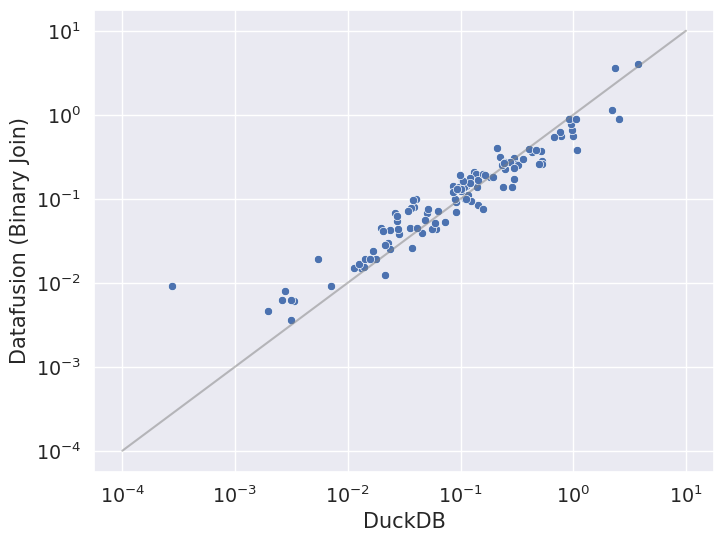

In [9]:
duckdb_datafusion = pd.merge(
    datafusion_bj_metrics[["query","hashjoin_time_datafusion"]],
    duckdb_df[["query","hashjoin_time(s)_duckdb"]],
    on="query"
)
ax = sns.scatterplot(data=duckdb_datafusion, x="hashjoin_time(s)_duckdb", y="hashjoin_time_datafusion")
ax.set_xlabel("DuckDB")
ax.set_ylabel("Datafusion (Binary Join)")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-4, 1e1)
# ax.set_ylim(1e-4, 1e1)
# plot diagonal from bottom left to top right
ax.plot([1e-4, 1e1], [1e-4, 1e1], color='grey', linestyle='-', alpha=0.5)

In [10]:
duckdb_datafusion["df/duckdb"] = duckdb_datafusion["hashjoin_time_datafusion"] / duckdb_datafusion["hashjoin_time(s)_duckdb"] 
print_stats(duckdb_datafusion["df/duckdb"], 0.01)

Total: 112, epsilon: 0.01
Number of dots above the line: 68 (60.71%)
Number of dots below the line: 41 (36.61%)
Number of dots on the line 3 (2.68%)


# 2NSA vs binary plans (in Datafusion)

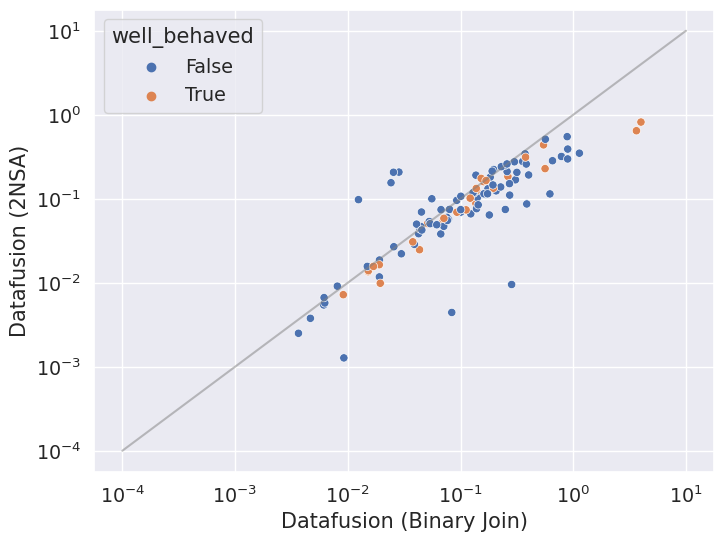

In [11]:
duckdb_bj_yann = pd.merge(
    duckdb_datafusion,
    yann_metrics[["query","yann_join_time_median"]],
    on="query"
)
duckdb_bj_yann = pd.merge(
    pd.read_csv("../../2phase_nsa/categories/job_categories.csv").set_index("query")[["well_behaved"]],
    duckdb_bj_yann,
    on="query"
)
ax = sns.scatterplot(data=duckdb_bj_yann, x="hashjoin_time_datafusion", y="yann_join_time_median", hue="well_behaved")
ax.set_xlabel("Datafusion (Binary Join)")
ax.set_ylabel("Datafusion (2NSA)")
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(1e-4, 1e1)
# ax.set_ylim(1e-4, 1e1)
# plot diagonal from bottom left to top right
ax.plot([1e-4, 1e1], [1e-4, 1e1], color='grey', linestyle='-', alpha=0.5)

In [12]:
duckdb_bj_yann["ratio"] = duckdb_bj_yann["yann_join_time_median"] / duckdb_bj_yann["hashjoin_time_datafusion"]
duckdb_bj_yann["diff"] = duckdb_bj_yann["yann_join_time_median"] - duckdb_bj_yann["hashjoin_time_datafusion"]
print_stats(duckdb_bj_yann["ratio"], 0.01)

Total: 112, epsilon: 0.01
Number of dots above the line: 23 (20.54%)
Number of dots below the line: 85 (75.89%)
Number of dots on the line 4 (3.57%)


In [13]:
print("Max. slowdown", duckdb_bj_yann["ratio"].max())
print("Max. abs. slowdown = {:.4f}s".format(duckdb_bj_yann["diff"].max()))
print("Max. speedup", (duckdb_bj_yann["hashjoin_time_datafusion"] / duckdb_bj_yann["yann_join_time_median"]).max())
print("Max. abs. speedup = {:.4f}s".format(abs(duckdb_bj_yann["diff"].min())))


Max. slowdown 8.13043143902574
Max. abs. slowdown = 0.1813s
Max. speedup 29.809635123094512
Max. abs. speedup = 3.1686s
